In [55]:
# Importing necessary Libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [58]:
# Creating the csv file

import os

root_dir = '/Users/tony/Documents/Project_1_DataSets/Multi-Label(Pens,Pencils,Both)/Images'
data = []

for label in os.listdir(root_dir):
    class_folder = os.path.join(root_dir, label)
    if not os.path.isdir(class_folder):
        continue
    for img_file in os.listdir(class_folder):
      if img_file.startswith('.'):
        continue
      img_path = os.path.join(label, img_file)
      data.append([img_path, label])

df = pd.DataFrame(data, columns=['image_path', 'label'])
df.to_csv('image_labels.csv', index=False)

save_path = '/Users/tony/Documents/Project_1_DataSets/image_labels.csv'
df.to_csv(save_path, index=False)

In [59]:
# Variables that set the file path for the dataset.

file_path_img = '/Users/tony/Documents/Project_1_DataSets/Multi-Label(Pens,Pencils,Both)/Images'
file_path_csv = '/Users/tony/Documents/Project_1_DataSets/image_labels.csv'

learning_rate = 0.00021
BATCH_SIZE = 16
num_of_epochs = 40

In [60]:
# Creating the DataLoader for reading images from a CSV file.

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

from PIL import Image

class custom_DataLoader(Dataset):
  def __init__(self,csv_file,img_dir,transform=None):
    self.df = pd.read_csv(csv_file)
    unique_labels = self.df.iloc[:, 1].unique() # Get unique values from the label column
    self.label_to_index = {label: index for index, label in enumerate(sorted(unique_labels))}
    self.index_to_label = {index: label for label, index in self.label_to_index.items()} # Optional, for debugging/verification
    self.num_classes = len(unique_labels)   # Store the number of unique classes

    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
      return len(self.df)


  def __getitem__(self, idx):
      img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])  # assuming first column is image filename
      image = Image.open(img_name).convert('RGB') # Ensure image is in a compatible format (e.g., RGB or L for grayscale)

        # Get the character label and convert it to its corresponding integer index
      char_label = self.df.iloc[idx, 1]
      if (char_label == "Pen"):
        label = [1,0]
      elif (char_label == "Pen_Pencil"):
        label = [1,1]
      else:
        label = [0,1]

        # Convert the integer index label to a PyTorch tensor
      label = torch.FloatTensor(label) # Use dtype=torch.long for CrossEntropyLoss

      if self.transform:
            # Apply the transform to the image (which should be a PIL Image now)
          image = self.transform(image)

      return image, label

In [61]:
# Pre-Processing Stage

transformations = transforms.Compose([
    # transforms.Grayscale(),
    transforms.Resize((32,32)),

    transforms.RandomRotation(12),
    # transforms.RandomVerticalFlip(0.6),
    transforms.ColorJitter(brightness=0.4,hue=0.3),
    transforms.RandomAffine(14),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [62]:
# Loading the data

dataset = custom_DataLoader(file_path_csv,file_path_img,transformations)


In [63]:
# Splits data into train set, validation set, and test set

total_size_dataset = len(dataset)
train_set_size = int(total_size_dataset * 0.7)
val_set_size = int(total_size_dataset * 0.15)
test_set_size = total_size_dataset - (train_set_size + val_set_size)

train_set, val_set, test_set = random_split(dataset, [train_set_size, val_set_size, test_set_size])

train_loader = DataLoader(train_set,BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_set,BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,BATCH_SIZE,shuffle=False)

loaders = {
    'train':train_loader,
    'validate':val_loader,
    'test':test_loader
}

name_of_classes = ['Pen','Pencil']


In [64]:
# Creating the Neural Network Architecture.

import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelClassifier(nn.Module):
    def __init__(self):
        """
        __init__(self)

        This initilizer creates the structure of the Neural Network. In this case
        it creates a Convolutional Neural Network (CNN) that has three 2D Convulutional
        layers.

        nn.BatchNorm2d(): BatchNormalization that is used to normalize the features
        extracted by the Convolutional layer.

        nn.Dropout2d(): Dropout Layer that is used to prevent the model from overfitting
        to the training set. Overfitting can cause the model to memorize specific images
        of the training set rather than generalize the features of images that belong to
        a class.

        dummy_input: This is a variable used to determine the shape of the input before the
        dense layer. This allows dynamic input calculation, which allows for flexible changes
        to image resolution and convulational layers.

        nn.Linear: This is the dense layer. It is used to determine the final output of the
        prediction after the data is processed in the Convulational layers.

        self.conv1 : First Convolutional Layer with a structure of convulation layer ->
        BatchNorm -> ReLU -> MaxPool structure

        self.conv2 : Second Convolutional Layer with a structure of convulation layer ->
        BatchNorm -> ReLU -> MaxPool structure

        self.conv3 : Third Convolutional Layer with a structure of convulation layer ->
        BatchNorm -> ReLU -> MaxPool structure

        self.conv4 : Fourth Convolutional Layer with a structure of convulation layer ->
        BatchNorm -> ReLU -> MaxPool structure
        """
        super(ModelClassifier, self).__init__()
        self.conv1 = nn.Sequential(
                      nn.Conv2d(3, 64, kernel_size=5, padding=1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2)
        )
        self.conv2 = nn.Sequential(
                      nn.Conv2d(64, 128, kernel_size=3, padding=1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2)
        )
        self.conv3 = nn.Sequential(nn.Conv2d(128,256,kernel_size=3, padding=1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2)
        )
        # self.conv3_drop = nn.Dropout2d()
        self.conv4 = nn.Sequential(nn.Conv2d(256,512,kernel_size=3, padding=1),
                    #  nn.Dropout2d(),
                     nn.BatchNorm2d(512),
                     nn.ReLU(),
                     nn.MaxPool2d(2,2)
        )
        self.drop = nn.Dropout(0.4)
        # Calculate the flattened size dynamically
        # Create a dummy tensor with the expected input dimensions (batch_size=1, channels=1, height=28, width=28)
        # The size needs to match the input image size after transformations (28x28 grayscale in your case)
        self.eval()

        dummy_input = torch.randn(1, 3, 32, 32)

        # # Pass the dummy input through the convolutional and pooling layers
        # # Ensure the operations match the forward pass up to the point of flattening
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        x = self.conv1(dummy_input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avg_pool(x)
        # Calculate the number of features before flattening

        self.train()
        self._to_linear = x.numel() // x.shape[0] # Divide by batch size

        self.dense = nn.Linear(self._to_linear, 300)
        self.out = nn.Linear(300, 2)

    def forward(self, x):
        """
        forward(self,x)

        This method is used to define the structure of the layers in the Neural
        Network. When data gets passed into the neural network, this is the order
        in which the data gets passed in.

        x: This variable the data that is being passed into the neural network.
        Typically this would be a flattened matrix that turns into a vector.
        """
      # Layer 1
        x = self.conv1(x)

      # Layer 2
        x = self.conv2(x)

      # Layer 3
        x = self.conv3(x)

      # Layer 4
        x = self.conv4(x)
        # x = x.view(-1, self._to_linear)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        # Layer 5
        x = F.relu(self.dense(x))

        x = self.drop(x)
        x = self.out(x)

        return torch.sigmoid(x)

In [65]:
# Creating the model,
# Defining the Validation and Training Stages
import torchvision
from torchvision import models

device = ''
if (torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'

model = ModelClassifier().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

loss_fn = nn.BCEWithLogitsLoss()

def validate(model,val_loader,loss_fn):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            val_loss += loss_fn(output, target).item()

            pred = (output > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.numel()

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total

    return val_loss, accuracy

def train(model,epochs,patience=5):
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0


    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(loaders['train']):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            # output = torch.sigmoid(output)
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pred = (output > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.numel()

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} '
                      f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

        # Validation phase
        val_loss, val_acc = validate(model, loaders['validate'], loss_fn)
        train_loss /= len(loaders['train'])
        train_acc = 100. * correct / total

        train_accuracy_list.append(train_acc)
        val_accuracy_list.append(val_acc)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f'\nEpoch {epoch}:')
        print(f'Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Validation loss improved. Model saved.')
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} epochs')
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch} epochs')
                break


    # plt.subplot(1,2,2)
    plt.plot(train_accuracy_list,label= 'Train Accuracy')
    plt.plot(val_accuracy_list,label= "Validation Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.xlabel("epocs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.subplot(1,2,1)
    plt.plot(train_loss_list,label="Training Loss")
    plt.plot(val_loss_list,label= "Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()


    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model


In [66]:
# Defining the testing stage

def test_model(model, test_loader, print_samples=5):
    model.eval()

    true_positives = torch.zeros(2).to(device)  # For Pen and Pencil
    false_positives = torch.zeros(2).to(device)
    false_negatives = torch.zeros(2).to(device)
    exact_matches = 0
    total_samples = 0

    # For sample printing
    samples_shown = 0
    class_names = ['Pen', 'Pencil']

    print("\nTesting model...")
    print("-" * 50)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()

            # Update statistics
            true_positives += (predicted * labels).sum(dim=0)
            false_positives += (predicted * (1 - labels)).sum(dim=0)
            false_negatives += ((1 - predicted) * labels).sum(dim=0)

            # Exact match ratio
            exact_matches += (predicted == labels).all(dim=1).sum().item()
            total_samples += labels.size(0)

            # Print sample predictions
            if samples_shown < print_samples:
                for i in range(labels.size(0)):
                    if samples_shown >= print_samples:
                        break

                    true_labels = [class_names[j] for j in range(2) if labels[i][j] == 1]
                    pred_labels = [class_names[j] for j in range(2) if predicted[i][j] == 1]

                    correct_str = "✓" if (predicted[i] == labels[i]).all() else "✗"
                    print(f"  {correct_str} Pred: {', '.join(pred_labels):<15} (True: {', '.join(true_labels)})")
                    samples_shown += 1

    # Calculate metrics
    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    exact_match_accuracy = 100. * exact_matches / total_samples

    print("\nClass-wise Performance:")
    print("-" * 50)
    for i in range(2):
        print(f"{class_names[i]:<15}")
        print(f"  Precision: {precision[i].item()*100:.2f}%")
        print(f"  Recall:    {recall[i].item()*100:.2f}%")
        print(f"  F1 Score:  {f1[i].item()*100:.2f}%")
        print("-" * 50)

    print(f"\nExact Match Accuracy: {exact_match_accuracy:.2f}%")
    print(f"(Percentage of samples where all labels were predicted correctly)")
    print("-" * 50)

    return {
        'precision': precision.cpu().numpy(),
        'recall': recall.cpu().numpy(),
        'f1': f1.cpu().numpy(),
        'exact_match_accuracy': exact_match_accuracy
    }

In [67]:
torch.save(model,'Pen_and_Pencil_md.pth')

In [68]:
layer_outputs = {}
def get_layer_output(name):
    """Hook function to store layer output"""
    def hook(model, input, output):
        layer_outputs[name] = output.detach()
    return hook

In [70]:
# Optimizing the thresholds for classes

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score # Import f1_score here

def find_optimal_thresholds(model, val_loader):
    """Find class-specific thresholds that maximize F1 score on validation set"""
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_outputs.append(outputs)
            all_labels.append(labels)

    # Concatenate all validation data
    outputs = torch.cat(all_outputs)
    labels = torch.cat(all_labels)

    # Find best threshold for each class
    optimal_thresholds = []
    for class_idx in range(2):  # For Pen (0) and Pencil (1)
        best_thresh = 0.5
        best_f1 = 0

        # Test 100 threshold values between 0 and 1
        for thresh in torch.linspace(0, 1, 100):
            preds = (outputs[:, class_idx] > thresh).float()
            # Use the imported f1_score
            f1 = f1_score(labels[:, class_idx].cpu(), preds.cpu())
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh.item()

        optimal_thresholds.append(best_thresh)

    return optimal_thresholds

In [72]:
# Defining the Prediction method and setting the thresholds

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Assuming device is defined globally as in your original notebook
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PenPencilClassifier:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = model.to(self.device)
        self.thresholds = [0.5, 0.5]  # Defaults before tuning
        self.class_names = ['Pen', 'Pencil']

        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
        ])

    def tune_thresholds(self, val_loader):
        self.model.eval()
        all_outputs = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                # Apply sigmoid to get probabilities
                outputs = torch.sigmoid(outputs)
                all_outputs.append(outputs)
                all_labels.append(labels)

        outputs = torch.cat(all_outputs)
        labels = torch.cat(all_labels)

        optimal_thresholds = []
        for class_idx in range(2):
            best_thresh = 0.5
            best_f1 = 0

            for thresh in torch.linspace(0, 1, 100):
                preds = (outputs[:, class_idx] > thresh).float()
                f1 = f1_score(labels[:, class_idx].cpu(), preds.cpu())
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = thresh.item()

            optimal_thresholds.append(best_thresh)

        self.thresholds = optimal_thresholds
        print(f"Optimized thresholds - Pen: {self.thresholds[0]:.2f}, Pencil: {self.thresholds[1]:.2f}")


    def predict(self, image_path):
        self.model.eval()

        try:
            img = Image.open(image_path).convert('RGB') # Ensure image is in RGB
            img_tensor = self.transform(img).unsqueeze(0).to(self.device)

            with torch.no_grad():
                output = self.model(img_tensor)
                # Apply sigmoid to the output to get probabilities between 0 and 1
                probabilities = torch.sigmoid(output)[0] # Get probabilities for the single image

            pen_prob, pencil_prob = probabilities[0].item(), probabilities[1].item()

            # Use class-specific thresholds for prediction
            has_pen = pen_prob > self.thresholds[0]
            has_pencil = pencil_prob > self.thresholds[1]

            print("\nPrediction Results:")
            print("-" * 30)
            predicted_labels = []
            if has_pen:
                predicted_labels.append("Pen")
            if has_pencil:
                predicted_labels.append("Pencil")

            if not predicted_labels:
                 print("Neither Pen nor Pencil")
            else:
                 print(" and ".join(predicted_labels))

            print("-" * 30)
            print(f"Confidence - Pen: {pen_prob:.2%}")
            print(f"Confidence - Pencil: {pencil_prob:.2%}")

            plt.imshow(img)
            plt.title(f"Prediction: {' and '.join(predicted_labels) if predicted_labels else 'None'}")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(f"Error: Image file not found at {image_path}")
        except Exception as e:
            print(f"An error occurred during prediction: {e}")

In [74]:
# Creating the Confusion Matrix for Evaluation

import matplotlib.pyplot as plt

def create_multilabel_confusion_matrix(model, test_loader, class_names, device, threshold=0.5):
    """
    Create a confusion matrix for multi-label classification.

    Args:
        model: Your trained model
        test_loader: DataLoader for test data
        class_names: List of class names (e.g., ['pen', 'pencil', 'both'])
        device: Device to run computations on
        threshold: Threshold for considering a prediction positive
    """
    model.eval()
    num_classes = len(class_names)

    # Initialize confusion matrices (one per class)
    confusion_matrices = {
        'tp': torch.zeros(num_classes),
        'fp': torch.zeros(num_classes),
        'fn': torch.zeros(num_classes),
        'tn': torch.zeros(num_classes)
    }

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            preds = (outputs > threshold).float()

            # For each class, calculate TP, FP, FN, TN
            for i in range(num_classes):
                true_pos = (labels[:, i] == 1) & (preds[:, i] == 1)
                false_pos = (labels[:, i] == 0) & (preds[:, i] == 1)
                false_neg = (labels[:, i] == 1) & (preds[:, i] == 0)
                true_neg = (labels[:, i] == 0) & (preds[:, i] == 0)

                confusion_matrices['tp'][i] += true_pos.sum().item()
                confusion_matrices['fp'][i] += false_pos.sum().item()
                confusion_matrices['fn'][i] += false_neg.sum().item()
                confusion_matrices['tn'][i] += true_neg.sum().item()

    # Plot individual confusion matrices for each class
    fig, axes = plt.subplots(1, num_classes, figsize=(5*num_classes, 5))

    for i, class_name in enumerate(class_names):
        ax = axes[i] if num_classes > 1 else axes
        cm = torch.tensor([
            [confusion_matrices['tp'][i], confusion_matrices['fn'][i]],
            [confusion_matrices['fp'][i], confusion_matrices['tn'][i]]
        ])

        # Normalize
        cm_normalized = cm / cm.sum()

        # Plot
        im = ax.imshow(cm_normalized.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'Class: {class_name.capitalize()}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Positive', 'Negative'])
        ax.set_yticklabels(['Positive', 'Negative'])

        # Add text annotations
        thresh = cm_normalized.max() / 2.
        for x in range(2):
            for y in range(2):
                ax.text(x, y, f"{cm[y, x]:.0f}\n({cm_normalized[y, x]*100:.1f}%)",
                       horizontalalignment="center",
                       color="white" if cm_normalized[y, x] > thresh else "black")

    plt.tight_layout()
    plt.show()

    return confusion_matrices

Epoch: 1 [0/294 (0%)]	Loss: 0.663318
Epoch: 1 [160/294 (53%)]	Loss: 0.649442

Epoch 1:
Train Loss: 0.6273 | Accuracy: 60.37%
Val Loss: 0.6293 | Accuracy: 71.43%
Validation loss improved. Model saved.
Epoch: 2 [0/294 (0%)]	Loss: 0.658848
Epoch: 2 [160/294 (53%)]	Loss: 0.625047

Epoch 2:
Train Loss: 0.6131 | Accuracy: 66.50%
Val Loss: 0.6036 | Accuracy: 76.19%
Validation loss improved. Model saved.
Epoch: 3 [0/294 (0%)]	Loss: 0.562306
Epoch: 3 [160/294 (53%)]	Loss: 0.603317

Epoch 3:
Train Loss: 0.6033 | Accuracy: 68.54%
Val Loss: 0.5850 | Accuracy: 77.78%
Validation loss improved. Model saved.
Epoch: 4 [0/294 (0%)]	Loss: 0.582021
Epoch: 4 [160/294 (53%)]	Loss: 0.591513

Epoch 4:
Train Loss: 0.5939 | Accuracy: 71.43%
Val Loss: 0.5787 | Accuracy: 70.63%
Validation loss improved. Model saved.
Epoch: 5 [0/294 (0%)]	Loss: 0.541871
Epoch: 5 [160/294 (53%)]	Loss: 0.608171

Epoch 5:
Train Loss: 0.5750 | Accuracy: 72.28%
Val Loss: 0.5734 | Accuracy: 74.60%
Validation loss improved. Model saved.


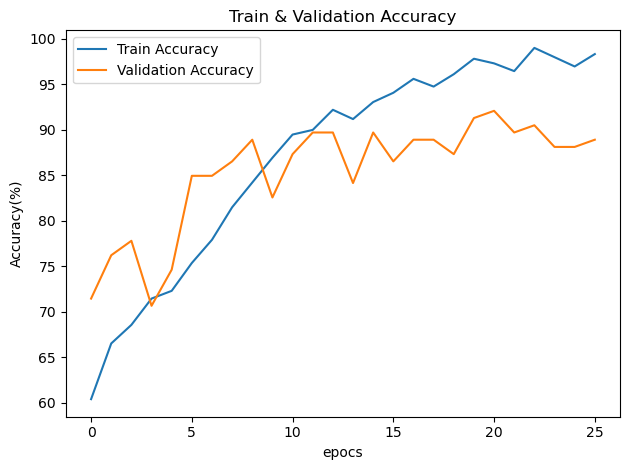

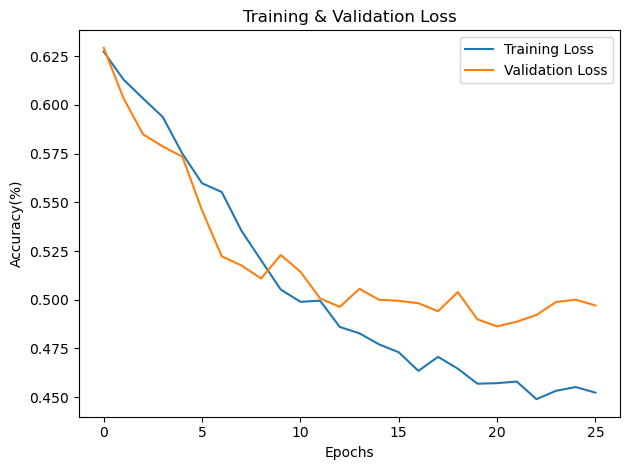

ModelClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1

In [75]:
# Training Stage

train(model,num_of_epochs)

In [76]:
# Testing Stage

test_model(model,test_loader)


Testing model...
--------------------------------------------------
  ✗ Pred:                 (True: Pen)
  ✗ Pred: Pen             (True: Pencil)
  ✓ Pred: Pen             (True: Pen)
  ✓ Pred: Pen, Pencil     (True: Pen, Pencil)
  ✓ Pred: Pencil          (True: Pencil)

Class-wise Performance:
--------------------------------------------------
Pen            
  Precision: 88.89%
  Recall:    93.02%
  F1 Score:  90.91%
--------------------------------------------------
Pencil         
  Precision: 89.19%
  Recall:    82.50%
  F1 Score:  85.71%
--------------------------------------------------

Exact Match Accuracy: 76.19%
(Percentage of samples where all labels were predicted correctly)
--------------------------------------------------


{'precision': array([0.8888889, 0.8918919], dtype=float32),
 'recall': array([0.9302326, 0.825    ], dtype=float32),
 'f1': array([0.90909094, 0.85714287], dtype=float32),
 'exact_match_accuracy': 76.19047619047619}

In [77]:
#(model,test_loader=test_loader,num_classes=num_classes,device=device)

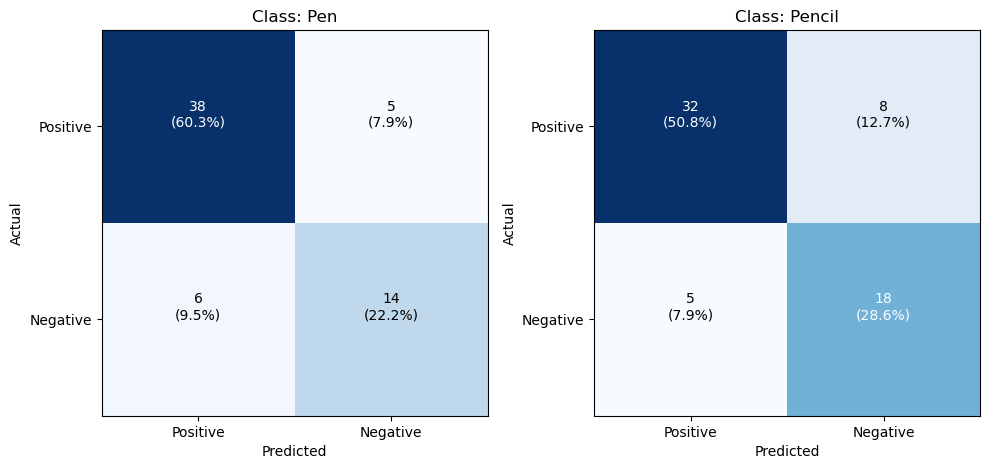

In [78]:
# Creating the Confusion Matrix 

confusion_matrices = create_multilabel_confusion_matrix(
    model,
    test_loader,
    class_names=name_of_classes,
    device=device,
    threshold=0.5
)


In [79]:
# Optimizing Threshold Stage

predictions = PenPencilClassifier(model)
predictions.tune_thresholds(val_loader)

Optimized thresholds - Pen: 0.69, Pencil: 0.57



Prediction Results:
------------------------------
Pencil
------------------------------
Confidence - Pen: 50.58%
Confidence - Pencil: 72.79%


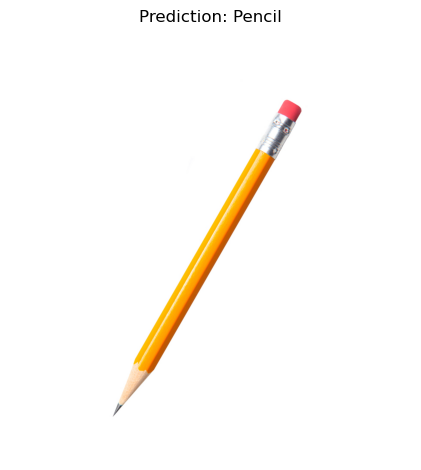

In [80]:
# Prediction Stage 1: Pencil 


predictions.predict('/Users/tony/Downloads/Test_images/pencil_280523090.jpg')



Prediction Results:
------------------------------
Pencil
------------------------------
Confidence - Pen: 59.30%
Confidence - Pencil: 72.98%


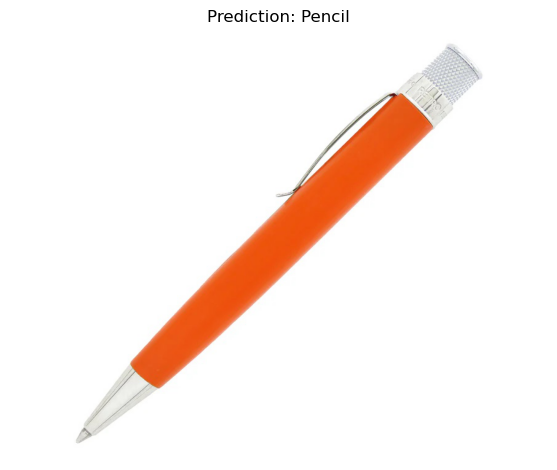

In [81]:
# Prediction Stage 2: Pen

predictions.predict( "/Users/tony/Downloads/Test_images/VRR-2452_seasonalTouchFall-autmnOrange_RB-02_875x700.jpg")




Prediction Results:
------------------------------
Pen and Pencil
------------------------------
Confidence - Pen: 73.09%
Confidence - Pencil: 66.17%


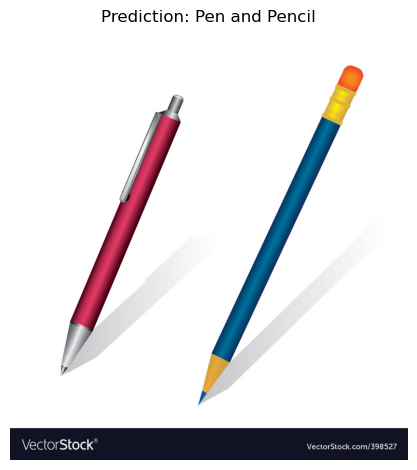

In [82]:
# Prediction Stage 3: Pencil and Pen

predictions.predict( "/Users/tony/Downloads/Test_images/Example_1.jpg")



Prediction Results:
------------------------------
Pen and Pencil
------------------------------
Confidence - Pen: 70.91%
Confidence - Pencil: 68.38%


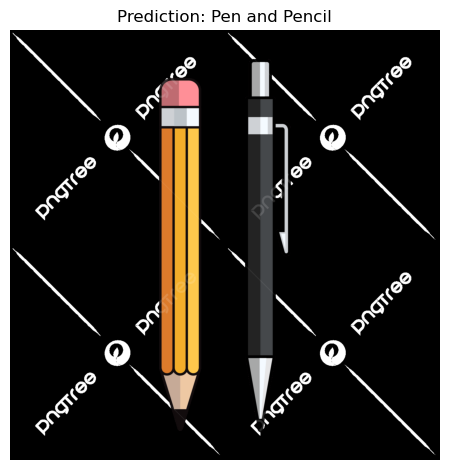

In [83]:
# Prediction Stage 4: Pencil and Pen

predictions.predict( "/Users/tony/Downloads/Test_images/Example_2.png")




Prediction Results:
------------------------------
Pencil
------------------------------
Confidence - Pen: 52.46%
Confidence - Pencil: 58.24%


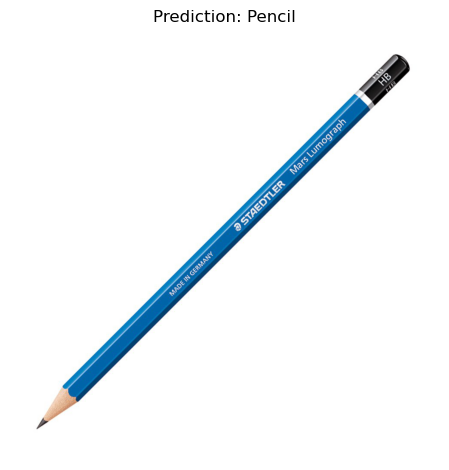

In [84]:
# Prediction Stage 5: Pencil 

predictions.predict("/Users/tony/Downloads/Test_images/51TkKa5QdgL.jpg")




Prediction Results:
------------------------------
Pencil
------------------------------
Confidence - Pen: 50.43%
Confidence - Pencil: 70.89%


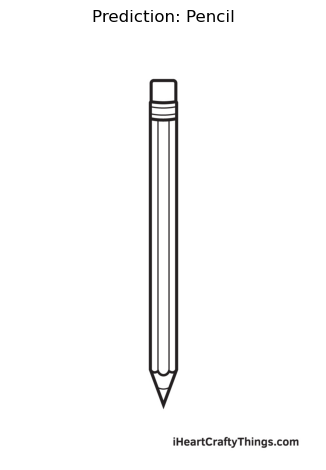

In [85]:
# Prediction Stage 6: Pencil 

predictions.predict("/Users/tony/Downloads/Test_images/Pencil-DRAWING-–-STEP-9.jpg")



Prediction Results:
------------------------------
Pen
------------------------------
Confidence - Pen: 73.09%
Confidence - Pencil: 50.64%


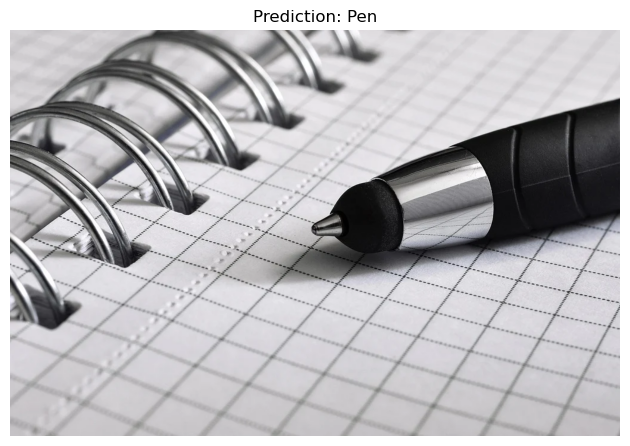

In [86]:
# Prediction Stage 7: Pen

predictions.predict("/Users/tony/Downloads/Test_images/bptip-1_1024x1024.jpg")



Prediction Results:
------------------------------
Neither Pen nor Pencil
------------------------------
Confidence - Pen: 64.99%
Confidence - Pencil: 53.45%


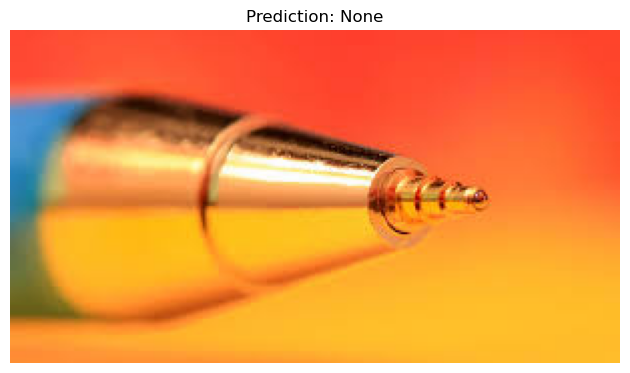

In [87]:
# Prediction Stage 8: Pen

predictions.predict("/Users/tony/Downloads/Test_images/imagesp.jpg")



Prediction Results:
------------------------------
Pen
------------------------------
Confidence - Pen: 73.07%
Confidence - Pencil: 50.63%


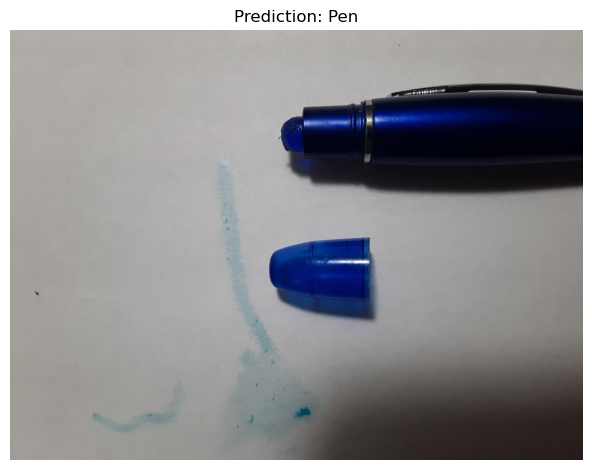

In [88]:
# Prediction Stage 9: Pen

predictions.predict("/Users/tony/Downloads/Test_images/ue2ilgr1xau21.jpg")



Prediction Results:
------------------------------
Pencil
------------------------------
Confidence - Pen: 50.06%
Confidence - Pencil: 73.07%


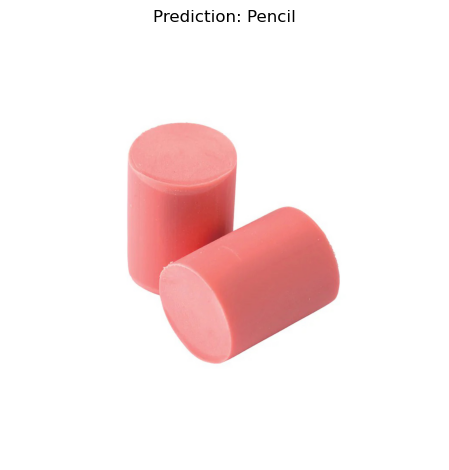

In [89]:
# Prediction Stage 10: Pencil 

predictions.predict("/Users/tony/Downloads/Test_images/Ohto_2_Eraser_Refill.jpg")




Prediction Results:
------------------------------
Pencil
------------------------------
Confidence - Pen: 56.97%
Confidence - Pencil: 73.05%


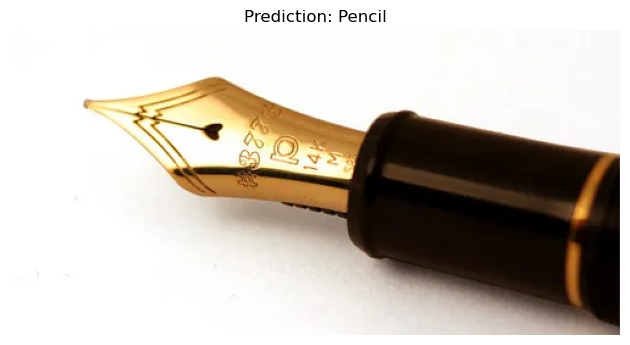

In [91]:
# Prediction Stage 11: Pen

predictions.predict("/Users/tony/Downloads/Test_images/IMG_6997.jpg")




Prediction Results:
------------------------------
Pen and Pencil
------------------------------
Confidence - Pen: 57.49%
Confidence - Pencil: 69.92%


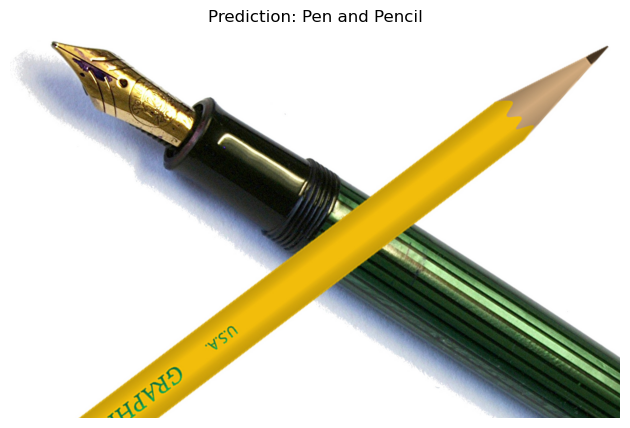

In [300]:
# Prediction Stage 12: Pencil and Pen

predictions.predict("/Users/tony/Downloads/Test_images/Pen-vs-Pencil.jpg")




Prediction Results:
------------------------------
Pen and Pencil
------------------------------
Confidence - Pen: 71.76%
Confidence - Pencil: 61.54%


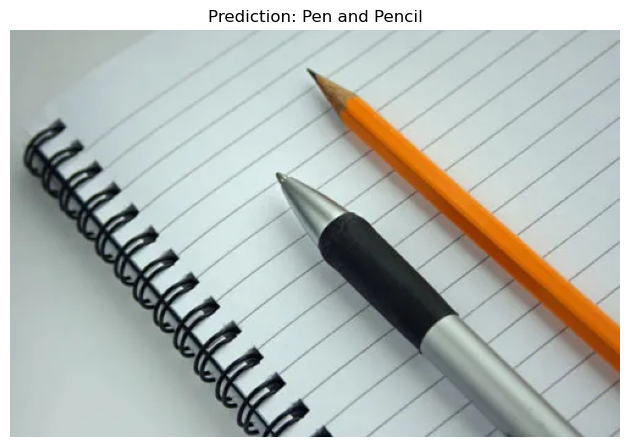

In [301]:
# Prediction Stage 13: Pencil and Pen

predictions.predict("/Users/tony/Downloads/Test_images/image13.jpg")




Prediction Results:
------------------------------
Pen and Pencil
------------------------------
Confidence - Pen: 72.27%
Confidence - Pencil: 67.78%


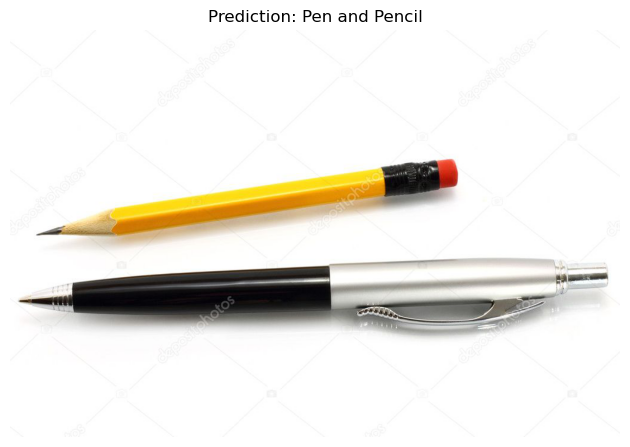

In [302]:
# Prediction Stage 14: Pencil and Pen

predictions.predict("/Users/tony/Downloads/Test_images/depositphotos_8213636-stock-photo-pen-and-pencil.jpg")

